In [2]:
from gym_maze.envs.maze_env import MazeEnvRandom30x30Plus

import time
import random
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pygame
import sys

In [3]:
env = MazeEnvRandom30x30Plus()

2022-05-03 00:33:20.828 Python[39122:3011561] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/p3/4j53xc_50yv4yqz952bnybrm0000gn/T/org.python.python.savedState


In [214]:
# Test code
env.reset()
for st in range(100):
    act = env.action_space.sample()
    env.step(act)
    env.render()
    time.sleep(.2)
    print(st)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


KeyboardInterrupt: 

In [16]:
def find_max_val_action_for_state(state_action_values, state):
    res_d = {}
    for k in state_action_values:
        if k[0] == state:
            res_d[k] = state_action_values[k]['value']
    if res_d:
        return max(res_d, key=res_d.get)[1]
    else:
        return env.action_space.sample()


def choose_greedy_action(best_action, eps):
    if np.random.uniform() < eps:
        next_action = best_action
    else:
        next_action = env.action_space.sample()

    return next_action


def update_state_action_values(state_action_values, 
                               cur_state, 
                               cur_action, 
                               reward, 
                               next_state, 
                               best_action,
                               verbose):

    local_cp = state_action_values.copy()


    if (cur_state, cur_action) in local_cp:
        val = local_cp[(cur_state, cur_action)]['value']
    else:
        local_cp[(cur_state, cur_action)] = {}
        val = 0
        local_cp[(cur_state, cur_action)]['value'] = val

    if (next_state, best_action) not in local_cp:
        local_cp[(next_state, best_action)] = {}
        local_cp[(next_state, best_action)]['value'] = 0
    if verbose:
        print('%'*30)
        print('UPDATING Q_VALUE')
        print('current val:', val)
        print('TD error', reward+lam*local_cp[(next_state, best_action)]['value'] - val)
        print('%'*30)
    local_cp[(cur_state, cur_action)]['value'] = \
        val+alpha*(reward+lam*local_cp[(next_state, best_action)]['value'] - val)


    return local_cp


def find_all_predecessors(world_map, state):
    res_lst = []
    for k in world_map:
        if world_map[k][0] == state:
            res_lst.append(k)
    return res_lst


def calc_val_change(cur_state, 
                    cur_action, 
                    reward, 
                    next_state, 
                    best_action, 
                    state_action_values,
                    verbose):
    local_cp = state_action_values.copy()


    if (cur_state, cur_action) in local_cp:
        val = local_cp[(cur_state, cur_action)]['value']
#         print(cur_state, cur_action, val)
    else:
        local_cp[(cur_state, cur_action)] = {}
        val = 0
        local_cp[(cur_state, cur_action)]['value'] = val

    if (next_state, best_action) not in local_cp:
        local_cp[(next_state, best_action)] = {}
        local_cp[(next_state, best_action)]['value'] = 0

    if verbose:
        print('^'*30)
        print('CURRENT:', (cur_state, cur_action), val)
        print('reward:', reward)
        print('lam:', lam)
        print('Value with best act:', local_cp[(next_state, best_action)]['value'])
        print('Res dif:', abs(reward+lam*local_cp[(next_state, best_action)]['value'] - val))
        print('^'*30)

    return abs(reward+lam*local_cp[(next_state, best_action)]['value'] - val)

# [cur_state, action, val_change]


def optimise_world(world_map, state_action_values, PQueue, change_thresh, verbose):

    local_state_action_values = state_action_values.copy()
    local_world_map = world_map.copy()

#     priority_move = list(np.array(PQueue, dtype=object)[np.array(PQueue, dtype=object)[:, 2].argsort()[::-1]][0])

    if verbose: 
        print('-'*30)
        print('PQueue:', PQueue)
        print('Best move:', priority_move)

#     PQueue.pop(PQueue.index(priority_move))

    (cur_state, cur_action) = random.choice(list(local_world_map.keys())) #(priority_move[0], priority_move[1]) #
    (next_state, reward) = local_world_map[(cur_state, cur_action)]
    best_action = find_max_val_action_for_state(local_state_action_values, next_state)
    if verbose: print('BEST ACT:', best_action)
    if verbose: print(f'VAL BEFORE {(cur_state, cur_action)}', local_state_action_values[(cur_state, cur_action)])
    local_state_action_values = update_state_action_values(local_state_action_values, 
                                                           cur_state, 
                                                           cur_action, 
                                                           reward, 
                                                           next_state, 
                                                           best_action, 
                                                           verbose=False)
    if verbose: print(f'VAL AFTER {(cur_state, cur_action)}', local_state_action_values[(cur_state, cur_action)])

#     all_preds = find_all_predecessors(local_world_map, cur_state)
#     if verbose: print('STATE', cur_state, 'ALL PREDS', all_preds)
#     for pred in all_preds:
#         (pred_cur_state, pred_action) = (pred[0], pred[1])
#         (pred_next_state, pred_rew) = local_world_map[pred]
#         pred_best_action = find_max_val_action_for_state(local_state_action_values, pred_next_state)
#         pred_val_change = calc_val_change(pred_cur_state, 
#                                           pred_action, 
#                                           pred_rew, 
#                                           pred_next_state, 
#                                           pred_best_action,
#                                           local_state_action_values,
#                                           verbose=False)
#         if verbose: print(pred, pred_val_change)
#         if pred_val_change > change_thresh:
#             tmp_q = [k for k in PQueue if k[0] == pred_cur_state and k[1] == pred_action]
#             if verbose: print('INNER TMP_Q:', tmp_q)
#             if not tmp_q:
#                 PQueue.append([pred_cur_state, pred_action, pred_val_change])
    return (local_state_action_values, PQueue)


def run_episode(env, cur_state, cur_action, policy, state_action_values, show=False):
    done = False
    trajectory = []
    while not done:
        next_state, reward, done, info = env.step(cur_action); next_state = tuple(next_state)
        if next_state in policy:
            next_action = policy[next_state]
        else:
            best_action = find_max_val_action_for_state(state_action_values, next_state)
            next_action =  choose_greedy_action(best_action, eps)

#             next_action = select_greedy_action(next_state, state_action_values, eps)

        # Now we have: (cur_state, cur_action, reward, new_state, next_action)
        trajectory.append((cur_state, cur_action, reward, next_state, next_action))
        print(len(trajectory))
        cur_state = next_state; cur_action = next_action
        if show:
            env.render()
            time.sleep(.2)
            clear_output(wait=True)

    return trajectory


def learn_episode(env, 
                  cur_state, 
                  cur_action, 
                  state_action_values, 
                  policy,
                  world_map,
                  ep_num,
                  PQueue,
                  change_thresh=0.000005,
                  verbose=True,
                  show=False):
    local_state_action_values = state_action_values.copy()
    local_policy = policy.copy()
    local_world_map = world_map.copy()
    ep_sum_reward = 0
    trajectory=[]
    done = False
    while not done:

        next_state, reward, done, info = env.step(cur_action); ep_sum_reward+=reward
        next_state = tuple(next_state)
        local_world_map[(cur_state, cur_action)] = (next_state, reward)

        best_action = find_max_val_action_for_state(local_state_action_values, next_state)
        next_action = choose_greedy_action(best_action, eps)
        val_change = calc_val_change(cur_state, cur_action, reward, next_state, 
                                     best_action, state_action_values, verbose=False)
        if val_change > change_thresh:
            tmp_q = [k for k in PQueue if k[0] == cur_state and k[1] == cur_action]
            if not tmp_q:
                if verbose: print('ADDED IN OUTTER:', [cur_state, cur_action, val_change])
                PQueue.append([cur_state, cur_action, val_change])

        local_policy[next_state] = best_action
        trajectory.append((cur_state, cur_action, reward, next_state))

        local_state_action_values = \
            update_state_action_values(local_state_action_values, cur_state, cur_action, reward, 
                                       next_state, best_action, verbose=False)

        if (ep_num > 0):
            st_num = 50 #round(2*np.sqrt(len(local_world_map)))
            for model_step in range(st_num): #2*len(local_world_map)
#                 if PQueue:
                if verbose: print('PQueue len:', len(PQueue))
                (local_state_action_values, PQueue) = optimise_world(local_world_map, 
                                                                     local_state_action_values, 
                                                                     PQueue, 
                                                                     change_thresh,
                                                                     verbose)
                    
        cur_state = next_state; cur_action = next_action

        if show:
            env.render()
            clear_output(wait=True)
            time.sleep(.3)

    return (trajectory, 
            local_state_action_values, 
            local_policy, 
            ep_sum_reward, 
            local_world_map, 
            PQueue)

In [17]:
eps = 0.6
alpha = 0.5
lam = 0.8

world_map = {}
state_action_values = {}
policy = {}
PQueue = []

episodes = 50
ep_sums = []
trajectories = []
for ep_num in range(episodes):
    cur_state = tuple(env.reset())
    cur_action =  env.action_space.sample()
    verbose = True if (ep_num > 0) else False
    print(f'EP NUM {ep_num} START')
    (trajectory, state_action_values, policy, ep_sum_reward, world_map, PQueue) = \
        learn_episode(env,
                      cur_state,
                      cur_action,
                      state_action_values,
                      policy,
                      world_map,
                      ep_num,
                      PQueue,
                      verbose=False,
                      show=False)
    trajectories.append(trajectory)
    ep_sums.append(ep_sum_reward)

    if ep_num%1==0:
        print(f'EP NUM {ep_num} END:', ep_sum_reward, len(trajectory))
        print('#'*30)

EP NUM 0 START
EP NUM 0 END: -2.373333333331711 30361
##############################
EP NUM 1 START
EP NUM 1 END: 0.2557777777778617 6699
##############################
EP NUM 2 START
EP NUM 2 END: 0.9908888888888889 83
##############################
EP NUM 3 START
EP NUM 3 END: 0.9891111111111112 99
##############################
EP NUM 4 START
EP NUM 4 END: 0.9787777777777779 192
##############################
EP NUM 5 START
EP NUM 5 END: 0.9812222222222223 170
##############################
EP NUM 6 START
EP NUM 6 END: 0.9903333333333333 88
##############################
EP NUM 7 START
EP NUM 7 END: 0.9887777777777778 102
##############################
EP NUM 8 START
EP NUM 8 END: 0.9841111111111112 144
##############################
EP NUM 9 START
EP NUM 9 END: 0.9887777777777778 102
##############################
EP NUM 10 START
EP NUM 10 END: 0.9884444444444445 105
##############################
EP NUM 11 START
EP NUM 11 END: 0.9912222222222222 80
##############################
E

In [ ]:
all_preds = find_all_predecessors(local_world_map, cur_state)

for pred in all_preds:
    (pred_cur_state, pred_action) = (pred[0], pred[1])
    (pred_next_state, pred_rew) = local_world_map[pred]
    pred_best_action = find_max_val_action_for_state(local_state_action_values, pred_next_state)
    pred_val_change = calc_val_change(pred_cur_state, 
                                      pred_action, 
                                      pred_rew, 
                                      pred_next_state, 
                                      pred_best_action,
                                      local_state_action_values,
                                      verbose=False)

(0.0, 500.0)

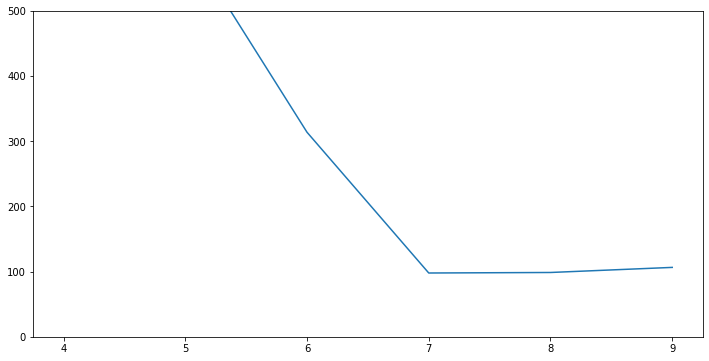

In [11]:
# PLOT TRAJECTORIES LENGTH


lens = []
for t in trajectories:#[:1500]:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(5).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
plt.ylim(0,500)

In [18]:
# POLICY DEMO
num_eps = 500

for eps in range(num_eps):
    cur_state = env.reset()
    cur_action = env.action_space.sample()
    new_episode = run_episode(env, 
                              cur_state, 
                              cur_action, 
                              policy, 
                              state_action_values, 
                              show=True)
    print('SUCCESSS!!! '*100)

46


KeyboardInterrupt: 

In [96]:
policy

{(0, 0): 2,
 (1, 0): 0,
 (1, 1): 0,
 (0, 1): 1,
 (0, 2): 1,
 (1, 2): 3,
 (0, 3): 1,
 (0, 4): 1,
 (0, 5): 1,
 (0, 6): 2,
 (1, 6): 2,
 (2, 6): 3,
 (3, 6): 1,
 (2, 2): 3,
 (2, 1): 1,
 (3, 1): 0,
 (3, 0): 3,
 (2, 0): 3,
 (3, 7): 1,
 (3, 8): 2,
 (4, 8): 2,
 (5, 8): 0,
 (5, 7): 3,
 (4, 7): 0,
 (4, 6): 0,
 (4, 5): 3,
 (3, 5): 0,
 (3, 4): 3,
 (2, 4): 0,
 (2, 3): 2,
 (3, 3): 2,
 (4, 3): 2,
 (5, 3): 0,
 (5, 2): 2,
 (6, 2): 2,
 (7, 2): 0,
 (7, 1): 3,
 (6, 1): 3,
 (5, 1): 3,
 (4, 1): 0,
 (4, 0): 2,
 (5, 0): 2,
 (6, 0): 2,
 (7, 0): 2,
 (1, 3): 2,
 (1, 4): 0,
 (1, 5): 0,
 (2, 5): 3,
 (4, 2): 0,
 (3, 2): 2,
 (8, 0): 1,
 (8, 1): 2,
 (9, 1): 1,
 (9, 2): 3,
 (8, 2): 1,
 (9, 0): 1,
 (8, 3): 2,
 (9, 3): 1,
 (9, 4): 3,
 (8, 4): 3,
 (7, 4): 3,
 (6, 4): 1,
 (6, 3): 1,
 (7, 3): 3,
 (6, 5): 1,
 (6, 6): 1,
 (5, 6): 2,
 (6, 7): 1,
 (6, 8): 2,
 (7, 8): 0,
 (7, 7): 0,
 (7, 6): 2,
 (8, 6): 2,
 (9, 6): 1,
 (9, 7): 3,
 (8, 7): 1,
 (8, 8): 1,
 (8, 9): 2,
 (7, 9): 2,
 (6, 9): 2,
 (5, 9): 1,
 (4, 9): 2,
 (3, 9): 2,
 (2,

# Prioritised sweeping